In [2]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import scripts.utils as utils
import numpy as np


import scripts.utils as utils

def upper_ci(mu, sigma):
    return mu + 1.96 * (sigma / np.sqrt(len(mu)))

def lower_ci(mu, sigma):
    return mu - 1.96 * (sigma / np.sqrt(len(mu)))


path = "/Users/alison/Documents/RAPID/correlation-analysis/code/scripts/"

config = utils.load_config(path)
backcasts = config['config']['backcasts']

plot_kwargs = {'bbox_inches': "tight", 'dpi': 200}

config = utils.load_config("scripts")
indir = config['paths']['resultsdir']
outdir = config['paths']['resultsdir']
figdir = config['paths']['figdir']

ts_dir = os.path.join(outdir, "nf", "full_timeseries")

RZ_ID = 36
buffer = 25
all_ts = glob.glob(os.path.join(ts_dir, f"wrz_{RZ_ID}", "*.parquet"))

eps = []
los = []
dfs = []
for file in all_ts:
    df = pd.read_parquet(file)
    df = df[df['buffer'] == buffer].copy()
    eps.append(df['ep_total'])
    los.append(df['LoS'])
    dfs.append(df)
    
# just take last file, i.e. last ensemble
# df = pd.concat(dfs)
df['Day'] = [1] * len(df)
df['date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])

mean_eps = pd.concat(eps, axis=1).mean(axis=1)
se_eps = pd.concat(eps, axis=1).std(axis=1, ddof=0)

<Axes: >

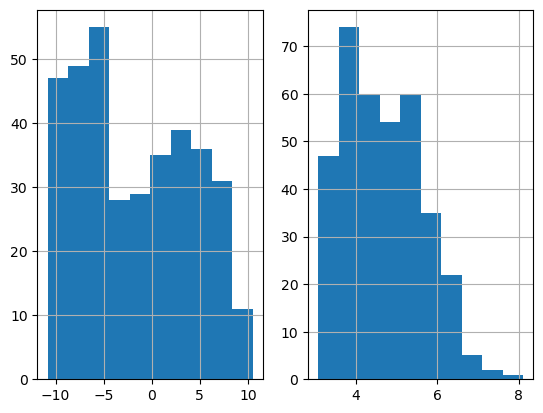

In [3]:
fig, ax = plt.subplots(1, 2)

mean_eps.hist(ax=ax[0])
se_eps.hist(ax=ax[1])

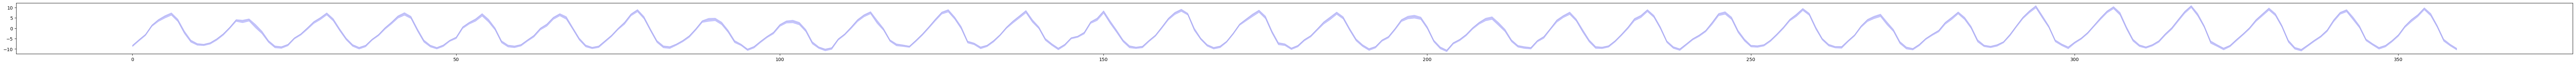

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(100, 2))
x = range(len(mean_eps))

ax.plot(x, mean_eps, linewidth=.1, color='k')
ax.fill_between(x, lower_ci(mean_eps, se_eps), upper_ci(mean_eps, se_eps), color='blue', alpha=0.2)

In [5]:
# grab time series for single ensemble/WRZ
ts = df.set_index('date')
ts_D = ts.diff(periods=12)
ts

# del dfs # temporary (saving memory)

,RZ_ID,Year,Month,LoS,buffer,ep_total,ep_mean,q50_anomaly_total,q75_anomaly_total,q90_anomaly_total,q50_deficit_total,Day
date,,,,,,,,,,,,
2020-01-01,36,2020,1,0.0,25.0,-7.000859,-2.333620,1.985772,-1.432181,-3.793537,0.000000,1
2020-02-01,36,2020,2,0.0,25.0,-10.969042,-3.656347,-4.411514,-7.162153,-8.690109,4.411514,1
2020-03-01,36,2020,3,0.0,25.0,-1.987605,-0.662535,2.003896,-0.530947,-2.677070,0.000000,1
2020-04-01,36,2020,4,0.0,25.0,-0.874780,-0.291593,-1.144219,-3.433624,-6.117130,1.144219,1
2020-05-01,36,2020,5,0.0,25.0,-1.832689,-0.610896,-4.624703,-7.834861,-10.334302,4.624703,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2049-08-01,36,2049,8,0.0,25.0,9.976306,3.325435,5.801597,2.385916,0.160320,0.000000,1
2049-09-01,36,2049,9,0.0,25.0,-0.916282,-0.305427,0.556683,-2.306360,-4.204094,0.000000,1
2049-10-01,36,2049,10,0.0,25.0,0.548581,0.182860,5.732758,2.320355,-0.010902,0.000000,1


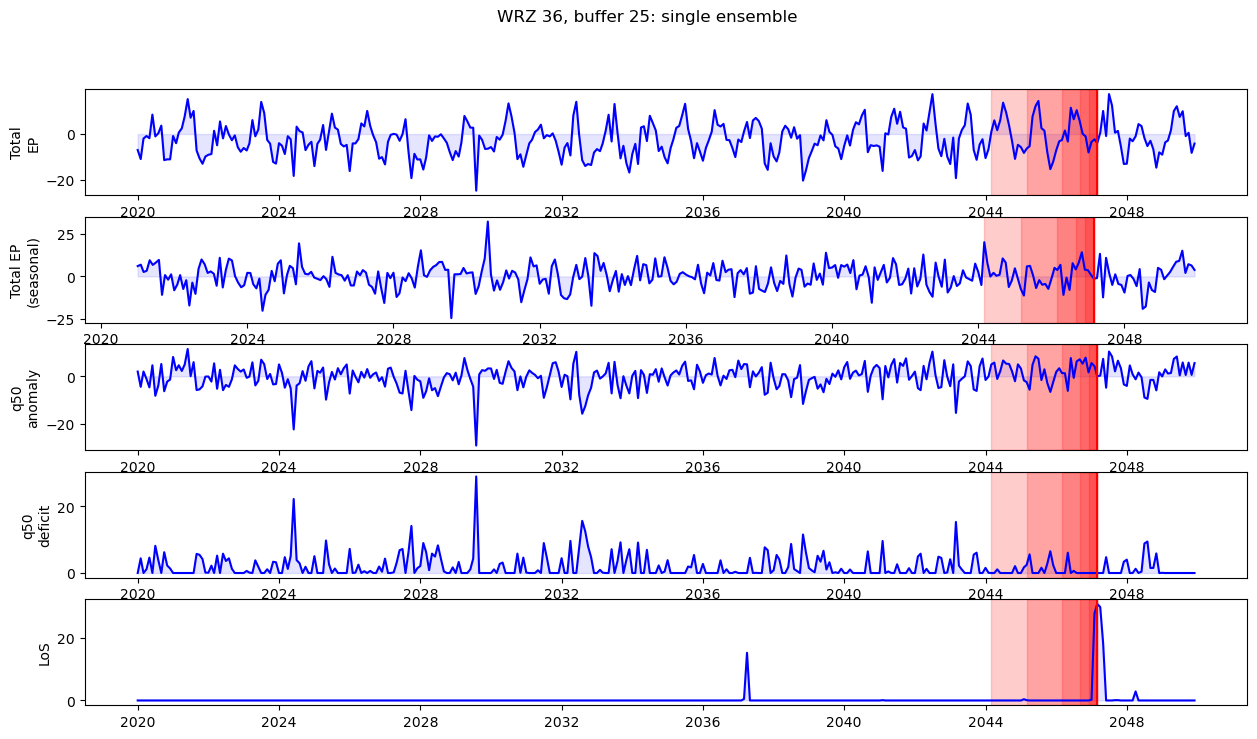

In [6]:
from dateutil.relativedelta import relativedelta

fig, ax = plt.subplots(5, 1, figsize=(15, 8))

ax[0].plot(ts['ep_total'], color='blue')
ax[0].fill_between(ts.index, ts['ep_total'], color='blue', alpha=.1)
ax[0].set_ylabel('Total\nEP')

ax[1].plot(ts_D['ep_total'], color='blue')
ax[1].fill_between(ts_D.index, ts_D['ep_total'], color='blue', alpha=.1)
ax[1].set_ylabel('Total EP\n(seasonal)')

ax[2].plot(ts['q50_anomaly_total'], color='blue')
ax[2].fill_between(ts.index, ts['q50_anomaly_total'], color='blue', alpha=.1)
ax[2].set_ylabel('q50\nanomaly')
# ax[2].set_ylim([-5, 5])

ax[3].plot(ts['q50_deficit_total'], color='blue')
ax[3].fill_between(ts.index, ts['q50_deficit_total'], color='blue', alpha=.1)
ax[3].set_ylabel('q50\ndeficit')
# ax[3].set_ylim([-5, 5])

ax[4].plot(ts['LoS'], color='blue')
ax[4].fill_between(ts.index, ts['LoS'], color='blue', alpha=.1)
ax[4].set_ylabel('LoS')


for a in ax:
    for time in ts.sort_values(by='LoS', ascending=False)[:1].index:
#     time = ts['LoS'].idxmax()
        a.axvline(x=time, color='red')

        for backcast in backcasts:
            start = time - relativedelta(months=backcast)
            a.axvspan(start, time, alpha=0.2, color='red')
        
fig.suptitle(f'WRZ {RZ_ID}, buffer {buffer}: single ensemble')
fig.savefig(os.path.join(figdir, 'timeseries', 'single-ensemble.png'), **plot_kwargs)

In [8]:
ts_orig = ts.copy()
ts.head()

,RZ_ID,Year,Month,LoS,buffer,ep_total,ep_mean,q50_anomaly_total,q75_anomaly_total,q90_anomaly_total,q50_deficit_total,Day
date,,,,,,,,,,,,
2020-01-01,36,2020,1,0.0,25.0,-7.000859,-2.333620,1.985772,-1.432181,-3.793537,0.000000,1
2020-02-01,36,2020,2,0.0,25.0,-10.969042,-3.656347,-4.411514,-7.162153,-8.690109,4.411514,1
2020-03-01,36,2020,3,0.0,25.0,-1.987605,-0.662535,2.003896,-0.530947,-2.677070,0.000000,1
2020-04-01,36,2020,4,0.0,25.0,-0.874780,-0.291593,-1.144219,-3.433624,-6.117130,1.144219,1
2020-05-01,36,2020,5,0.0,25.0,-1.832689,-0.610896,-4.624703,-7.834861,-10.334302,4.624703,1


# Vector autoregressive models
[Using nice Python VAR tutorial](https://www.statsmodels.org/devel/vector_ar.html)

In [70]:
import statsmodels.api as sm
from statsmodels.tsa.api import VAR

indicators = ['ep_total','q50_deficit_total']
ts = ts[['LoS'] + indicators]

model = VAR(ts)
results = model.fit(maxlags=15, ic='aic')
results.summary()

/Users/alison/mambaforge/envs/general/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 02, Aug, 2023
Time:                     13:24:14
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    7.33806
Nobs:                     347.000    HQIC:                   6.53691
Log likelihood:          -2399.31    FPE:                    407.473
AIC:                      6.00689    Det(Omega_mle):         293.734
--------------------------------------------------------------------
Results for equation LoS
                           coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------
const                         0.295545         0.238447            1.239           0.215
L1.LoS                        0.862622         0.057404           15.027           0.000
L1.ep_total                   

In [93]:
print(results.test_causality('LoS', indicators[0], kind='f').summary())
print('\n')
print(results.test_causality('LoS', indicators[1], kind='f').summary())

Granger causality F-test. H_0: ep_total does not Granger-cause LoS. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value     df   
-----------------------------------------------
         1.567          1.731   0.089 (13, 921)
-----------------------------------------------


Granger causality F-test. H_0: q50_deficit_total does not Granger-cause LoS. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value     df   
-----------------------------------------------
         1.099          1.731   0.356 (13, 921)
-----------------------------------------------


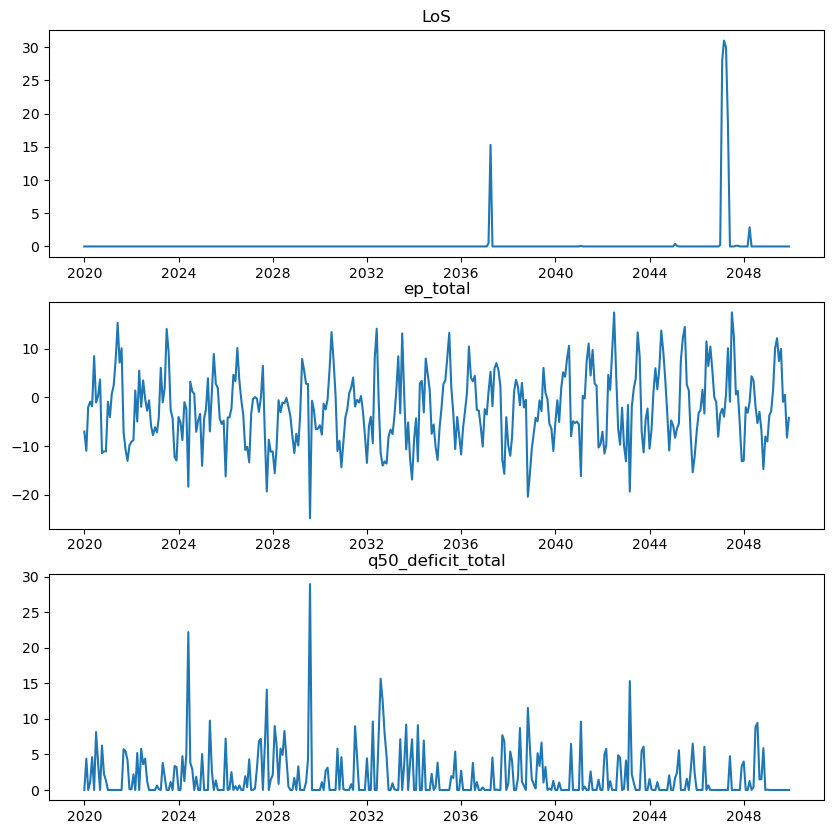

In [76]:
results.plot();

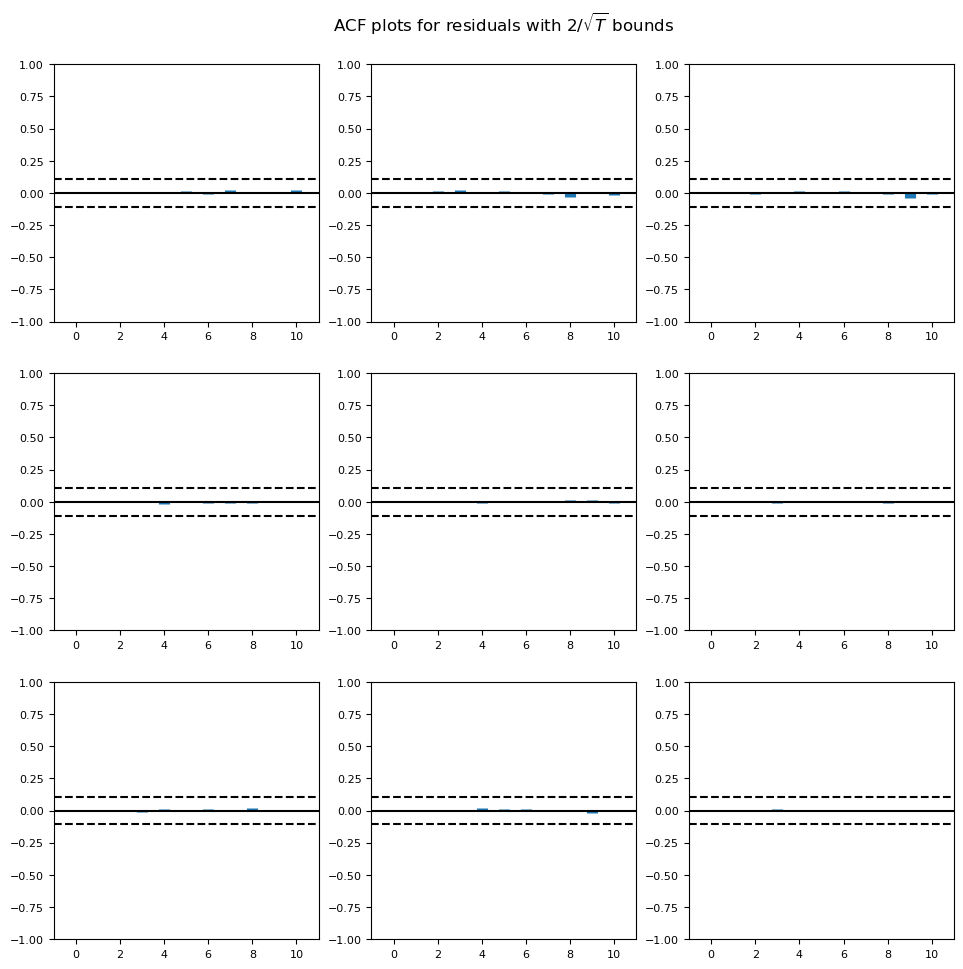

In [77]:
results.plot_acorr();

In [78]:
lag_order = results.k_ar
lag_order

13

In [79]:
results.forecast(ts.values[-lag_order:], 5)

array([[ 1.91774528, -6.12005756, -0.53221468],
       [ 2.32592107, -8.14866239,  1.82730506],
       [ 2.62860704, -0.01512837, -0.5156158 ],
       [ 2.82680067, -0.79443255,  2.6566194 ],
       [ 1.87611657,  5.50643496,  2.10361761]])

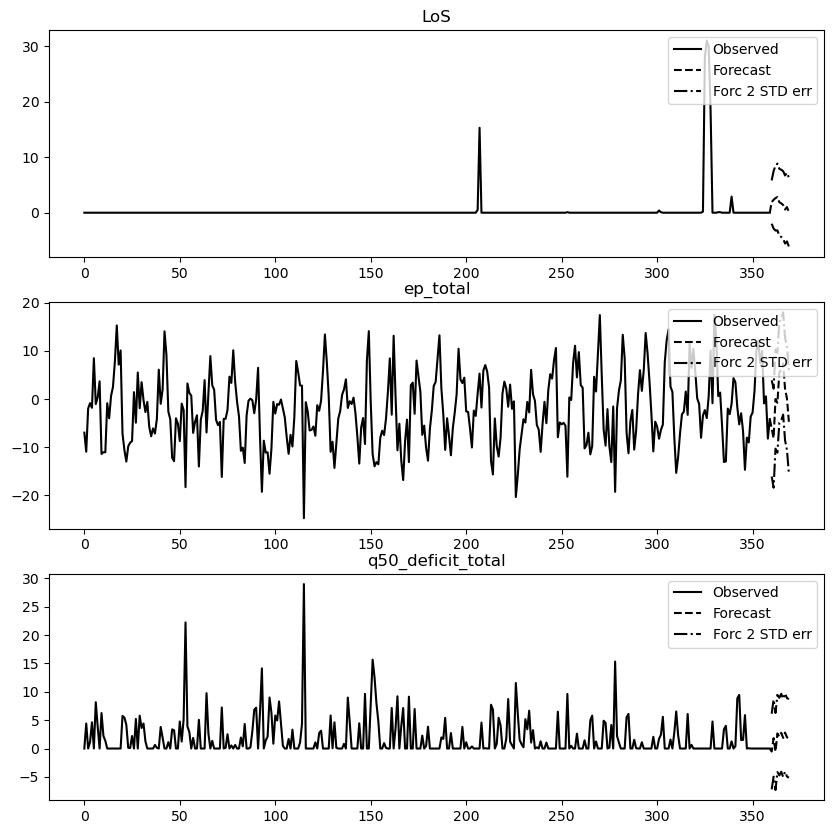

In [80]:
results.plot_forecast(10);

In [81]:
irf = results.irf(10)

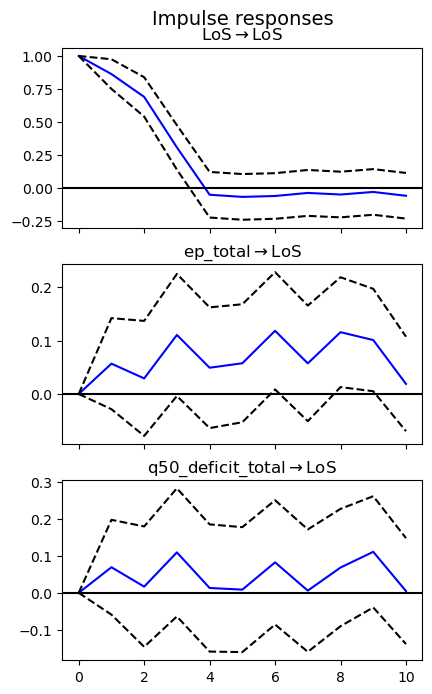

In [92]:
irf.plot(orth=False, response='LoS', figsize=(4, 7),
         plot_params={'fontsize' : 8});


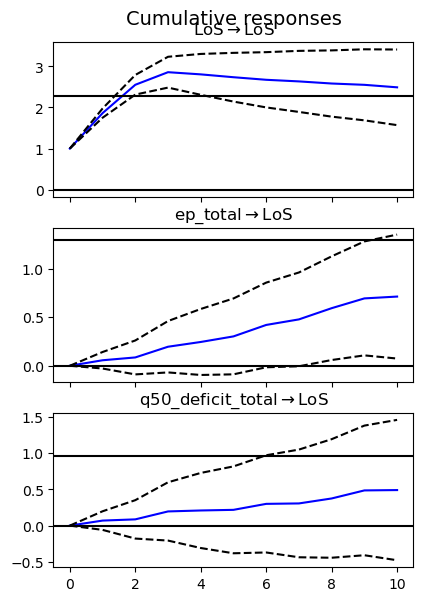

In [89]:
irf.plot_cum_effects(orth=False, response='LoS', figsize=(4, 6),
         plot_params={'fontsize' : 8});



# GAMLSS models

In [14]:
ts = ts_orig.copy()
ts['LoS'] = ts['LoS'].astype(int)  # want to fit a Poisson model (this is very approximate)
print(ts['LoS'].unique())

[ 0 15 28 31 30 18  2]


In [20]:
# too hard to do in Python, exporting to R
ts.to_csv(os.path.join(outdir, 'for_r', 'sample_ts.csv'))